## 01. Exploring parameters in DM halos and sub-halos

The notebook is divided into the following sections:
1. Loading data and defining input parameters
2. Studying sizes of haloes and sub-haloes

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 23rd February 2021

Import required packages

In [97]:
import astropy.units as u
import astropy.io.fits as fits
from astropy.table import Table, Column

import numpy as np

# system imports
import os
import sys
import importlib as ib

# plotting imports
import matplotlib
from mpl_toolkits import axes_grid1
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from matplotlib.legend_handler import HandlerLine2D

Load the imported file(s) that contains all the functions used in this notebooks

In [72]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

In [69]:
sys.path.append('imported_files/')
import Exploring_DM_Haloes as edh
import plotting as pt

There exists 734 pixels in the simulation, each covering 53 deg$^2$ in the sky. However, there are few pixels for which there exists only a galaxy file, but no AGN file (for example: 700-734). We start off by exploring arbitary particular pixel that covers all the way from redshift $z = 0-5.6$.

### 1. Defining input parameters

In [74]:
# look back into redshifts until...
redshift_limit = 4

# agn parameters
agn_FX_soft, agn_SDSS_r_magnitude = 4e-15, 24.5

# galaxy parameters
galaxy_FX_soft, galaxy_SDSS_r_magnitude = 4e-15, 24.5

# halo parameters
clu_FX_soft, galaxy_mag_r = 1e-13, 24.5
min_cluster_mass = 1e13 # solar masses

cluster_params = [clu_FX_soft, galaxy_mag_r, min_cluster_mass]

### 2. Open files and get relevant data

In [75]:
# halo directory number
pixel_no = '000000'

agn_filename = edh.getFilename('agn', pixel_no = pixel_no)
galaxy_filename = edh.getFilename('galaxy', pixel_no = pixel_no)

# halo files are divided into multiple groups
# TODO: create new object that saves them together
halo_filename0 = edh.getFilename('halo', pixel_no = [pixel_no, 0])
halo_filename1 = edh.getFilename('halo', pixel_no = [pixel_no, 1])
halo_filename2 = edh.getFilename('halo', pixel_no = [pixel_no, 2])

# read the input agn and galaxy files
hd_agn = Table.read(agn_filename, format='fits') 
hd_galaxy = Table.read(galaxy_filename, format='fits')

# read the input halo files
hd_halo0 = Table.read(halo_filename0, format='fits')
hd_halo1 = Table.read(halo_filename1, format='fits')
hd_halo2 = Table.read(halo_filename2, format='fits')

Extracting positions and redshifts of the AGNs, galaxies, and halos

In [76]:
# halos
pos_z_clu = edh.getClusterPositionsRedshift(hd_halo0, hd_halo1, hd_halo2, cluster_params, redshift_limit)

# agns
redshift_limit_agn = np.max(pos_z_clu[2])+0.1
pos_z_AGN = edh.getAgnData(hd_agn, agn_FX_soft, agn_SDSS_r_magnitude, redshift_limit=redshift_limit_agn)    

# galaxies i.e. non-active galaxies
pos_z_gal = edh.getGalaxyData(hd_galaxy, galaxy_mag_r, redshift_limit_agn)

In [110]:
print('AGNs/haloes in the pixel are in z = %.2f to %.2f'%(np.min(pos_z_AGN[2]), np.max(pos_z_AGN[2])))
print('%d clusters, %d AGNs, %d galaxies'%(len(np.unique(pos_z_clu[2])), len(pos_z_AGN[2]), len(pos_z_gal[0])))

AGNs/haloes in the pixel are in z = 0.03 to 0.81
9 clusters, 2608 AGNs, 850595 galaxies


### 3. Study distribution of AGNs in haloes

Plotting the chosen pixel with the galaxies, AGNs and clusters therein. Note that this plot comprises of objects in the defined reshift range.

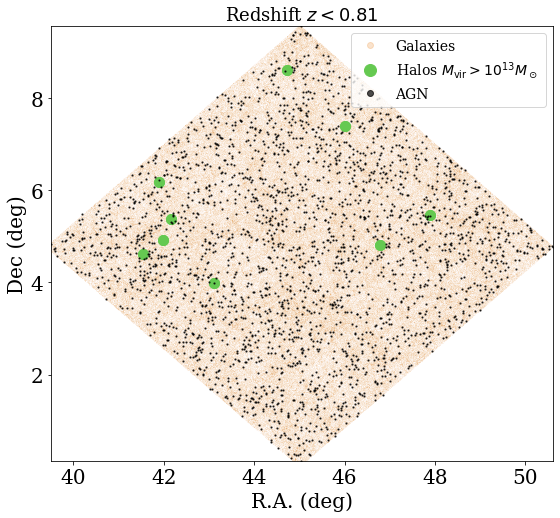

In [100]:
pt.plotAgnClusterDistribution(pos_z_clu, pos_z_AGN, pos_z_gal, min_cluster_mass)

Plotting the AGN/galaxy ratio as a function of the chosen redshift bins.

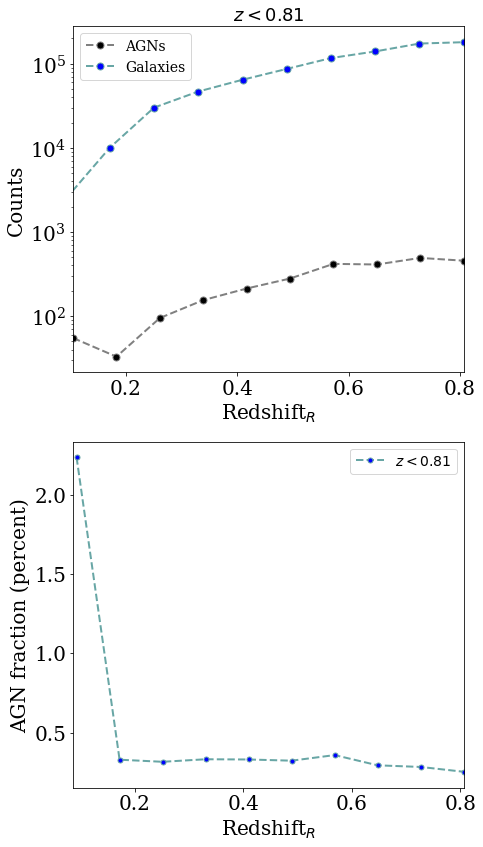

In [102]:
pt.plotAGNfraction(pos_z_clu, pos_z_AGN, pos_z_gal, redshift_limit_agn) 